In [90]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn import set_config; set_config(display='diagram')

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, StandardScaler, RobustScaler
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.cluster import KMeans
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer, make_column_transformer

In [2]:
dfbrew = pd.read_csv("../raw_data/Beers_Breweries_and_Beer Reviews/breweries.csv")
dfbeer = pd.read_csv("../raw_data/beers_style_renamed.csv")
dftop = pd.read_csv("../raw_data/top_beer_info_style_renamed.csv")

In [3]:
#read correspondance brewery
corres_xls = pd.read_excel('../assets/correspondance_breweryclean2.xlsx')
corres_xls.drop(columns='Unnamed: 0', inplace=True)
corres_xls.set_index(1, inplace=True)
corres= corres_xls.to_dict()
corres[0]

/Users/alix/.pyenv/versions/3.8.6/envs/zytholic_project/lib/python3.8/site-packages/openpyxl/worksheet/_reader.py:312: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


{'Hops and Grain Brewery': 'Hops & Grain Brewing',
 'Crazy Mountain Brewing Company': 'Crazy Mountain Brewery',
 'French Broad Brewing Co.': 'French Broad River Brewing',
 'Anheuser-Busch': 'Budweiser Brewing Group UK&I',
 'Timothy Taylor & Co. Limited': "Timothy Taylor's Brewery",
 'Andean Brewing Company': 'Andean Brewing Company / Nap Time Liquid Creation',
 'Paulaner Brauerei GmbH & Co. KG': 'Paulaner Brauerei',
 'Augustiner-Bräu Wagner KG': 'Augustiner-Bräu',
 'Hanseatische Getränke-Industrie (HGI) Holsten-Brauerei AG': 'Holsten-Brauerei',
 'Spoetzl Brewery / Shiner': 'Spoetzl Brewery',
 'Perrin Brewery': 'Perrin Brewing Co.',
 'Brauerei Ladenburger GmbH': 'Brauerei Ladenburger',
 'Other Half Brewing Co.': 'Other Half Brewing Company',
 'Gentse Stadsbrouwerij': 'Gentse Gruut Brouwerij',
 'Atlantic Brewing Company / Mainely Meat BBQ': 'Atlantic Brewing Company',
 'Indeed Brewing Company': 'Indeed Brewing Company - Minneapolis',
 'Big Storm Brewing Company': 'Big Storm Brewing Compa

In [26]:
dfbrew = dfbrew.rename(columns={"name": "brewery"})
dfbrew = dfbrew.rename(columns={"id": "brewery_id"})

dfbrew['brewery'].replace(corres[0], inplace=True)

dfbrewb =  pd.merge(dfbeer,dfbrew[['brewery_id','brewery']],how='left',on=['brewery_id'])

dftopbrew = pd.merge(dftop,dfbrewb[['name', 'brewery', 'state', 'country', 'retired']],
                     how='inner',on=['name','brewery'])

In [44]:
working_df = dftopbrew.drop(['description', 'key', 'style key'], axis= 1).drop_duplicates()
print(working_df.shape)
working_df = working_df[working_df.retired == 'f']
working_df.shape
working_df['style'] = [st.split(' - ')[0] for st in working_df['style']]

(4377, 21)


In [46]:
working_df['style'].nunique()

89

In [50]:
working_df.brewery.nunique(),working_df.state.nunique(), working_df.country.nunique()


(1315, 64, 60)

In [73]:
working_df.columns

Index(['name', 'style', 'brewery', 'abv', 'ave rating', 'min ibu', 'max ibu',
       'astringency', 'body', 'alcohol', 'bitter', 'sweet', 'sour', 'salty',
       'fruits', 'hoppy', 'spices', 'malty', 'state', 'country', 'retired'],
      dtype='object')

In [57]:
working_df['style'].unique()

array(['Altbier', 'Barleywine', 'Bitter Strong', 'Bitter',
       'Bière de Champagne / Bière Brut', 'Ale Blonde', 'Doppelbock',
       'Eisbock', 'Maibock', 'Bock', 'Weizenbock', 'Braggot', 'Brett',
       'Ale Brown', 'Steam Beer', 'Beer', 'Ale Cream', 'Dubbel',
       'Bière de Garde', 'Sahti', 'Saison', 'Fruit and Field Beer',
       'Ale Gruit / Ancient Herbed', 'Happoshu', 'Herb and Spice Beer',
       'IPA', 'NEIPA', 'Kvass', 'Kölsch', 'Lager', 'Lager Red Amber',
       'Lager Dark', 'Lager Pale', 'Lager Strong', 'Lager Helles',
       'Lager India Pale', 'Lager Rice', 'Lager Kellerbier / Zwickelbier',
       'Lager Light', 'Malt Liquor', 'Lager Munich Dunkel',
       'Lager Märzen / Oktoberfest', 'Lager Rauchbier',
       'Lager Schwarzbier', 'Faro', 'Lambic Fruit- Belgian', 'Gueuze',
       'Lambic', 'Low Alcohol Beer', 'Ale Dark Mild', 'Ale Pale',
       'Ale Old', 'Pilsener Bohemian', 'Pilsner', 'Porter',
       'Porter Baltic', 'Porter Imperial', 'Porter Robust',
       'Po

In [62]:
tastes_features = working_df.select_dtypes(np.number).columns[2:]
tastes_features

Index(['min ibu', 'max ibu', 'astringency', 'body', 'alcohol', 'bitter',
       'sweet', 'sour', 'salty', 'fruits', 'hoppy', 'spices', 'malty'],
      dtype='object')

In [108]:
X_train, X_test = train_test_split(working_df, test_size=0.25)
X_train

,name,style,brewery,abv,ave rating,min ibu,max ibu,astringency,body,alcohol,...,sweet,sour,salty,fruits,hoppy,spices,malty,state,country,retired
704,Get Up Offa That Brown,Ale Brown,Golden Road Brewing,5.50,3.72,15,25,6,70,8,...,68,11,0,8,42,7,155,CA,US,f
2008,Pious Monk Dunkel,Lager Munich Dunkel,Church Brew Works,4.30,3.61,15,25,22,55,7,...,91,23,0,48,31,10,121,PA,US,f
421,Gruffmeister 8,Maibock,Foothills Brewing Company - Downtown Brewpub,8.00,3.64,20,38,19,34,38,...,54,25,1,23,42,3,89,NC,US,f
2651,Imperial Spruce India Pilsner,Pilsner,Short's Brewing Company,7.15,4.00,30,65,14,25,15,...,11,8,2,17,95,2,19,MI,US,f
2744,Caramelized Chocolate Churro Baltic Porter,Porter Baltic,Moody Tongue Brewing Company,7.00,3.99,25,45,13,106,4,...,102,13,2,6,10,33,113,IL,US,f
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3395,Gypsy Tart,Sour Oud Bruin,Bruery Terreux,8.40,3.92,20,25,25,37,10,...,75,123,1,73,12,7,43,CA,US,f
964,Valhalla,Sahti,El Rancho Brewing Company,7.60,3.99,0,0,0,0,0,...,0,0,0,0,0,0,0,CO,US,f
1243,Thai Style White IPA,IPA,Upslope Brewing Company - Lee Hill,6.50,3.74,50,80,20,29,20,...,12,48,3,48,105,78,24,CO,US,f
851,Père Jacques,Dubbel,Goose Island Beer Co.,8.70,3.94,15,30,8,44,18,...,106,20,0,67,13,15,79,IL,US,f


In [109]:
pipe_style_country = make_pipeline(OneHotEncoder(sparse=False, handle_unknown='ignore'))
pipe_abv_rating = make_pipeline(StandardScaler())
pipe_taste_features = make_pipeline(MinMaxScaler())
pipe_state = make_pipeline(
    SimpleImputer(strategy='constant', fill_value=''),
    OneHotEncoder(sparse=False, handle_unknown='ignore')
)

preprocess = make_column_transformer(
    (pipe_style_country, ['style', 'country']),
    (pipe_state, ['state']),
    (pipe_abv_rating, ['abv', 'ave rating']),
    (pipe_taste_features, tastes_features)
    
)

In [110]:
preprocess.fit(X_train)
X = preprocess.transform(X_train)
y = preprocess.transform(X_test)

In [111]:
X.shape, y.shape

((3243, 223), (1082, 223))

In [88]:
res.inertia_

9889.049863757504

In [96]:

inertias2 = []
for k in range(30, 100):
    res = KMeans(n_clusters=k)
    res.fit(X)
    inertias.append(res.inertia_)

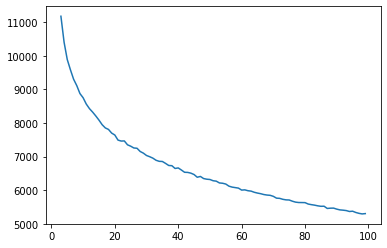

In [97]:
plt.plot(range(3, 100),inertias)

In [112]:
inertias2 = []
for k in range(10, 30):
    res = KMeans(n_clusters=k)
    res.fit(X)
    inertias2.append(res.inertia_)

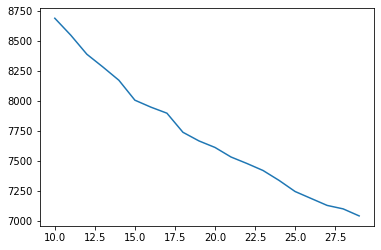

In [113]:
plt.plot(range(10, 30),inertias2)

In [114]:
cluster = KMeans(n_clusters=20)
cluster.fit(X)

KMeans(n_clusters=20)

In [115]:
X_test['group'] = cluster.predict(y)

/var/folders/_5/s9wbxcy503dggw34b98btk9c0000gp/T/ipykernel_12698/319366407.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_test['group'] = cluster.predict(y)


In [121]:
X_test.group.value_counts()

3     152
6     106
15    104
12     83
0      68
11     64
4      54
7      54
1      48
18     45
2      44
8      43
14     41
10     40
13     37
9      33
16     20
5      19
17     16
19     11
Name: group, dtype: int64

In [125]:
X_test[X_test.group == 16]

,name,style,brewery,abv,ave rating,min ibu,max ibu,astringency,body,alcohol,...,sour,salty,fruits,hoppy,spices,malty,state,country,retired,group
1290,NetherWorld Cascadian Dark Ale,IPA,Flying Monkeys Craft Brewery,6.0,3.85,50,70,30,72,8,...,41,0,53,115,13,111,ON,CA,f,16
753,Slingshot,Steam Beer,Radical Road Brewing Co.,5.0,3.67,35,45,6,11,1,...,0,0,0,22,1,17,ON,CA,f,16
1071,Buenos Dias,Ale Gruit / Ancient Herbed,Beau's All Natural Brewing Company,4.5,3.71,0,0,15,13,1,...,63,26,72,25,4,23,ON,CA,f,16
737,33 Acres Of Life,Steam Beer,33 Acres Brewing Co.,4.8,3.78,35,45,5,4,4,...,4,0,4,10,5,11,BC,CA,f,16
841,Cosmic Cream Ale,Ale Cream,Cameron's Brewing Co.,5.0,3.27,10,22,11,63,10,...,29,2,27,37,14,74,ON,CA,f,16
3620,Martello Stout,Stout,Garrison Brewing Company,4.8,3.89,20,40,10,83,6,...,4,0,3,30,12,139,NS,CA,f,16
2778,Stranger Than Fiction,Porter,Collective Arts Brewing,5.5,4.01,20,30,19,113,10,...,16,0,18,49,21,137,ON,CA,f,16
1347,Dead Elephant,IPA,Railway City Brewing Company,6.5,3.58,35,60,22,34,12,...,57,0,75,90,8,63,ON,CA,f,16
1086,La Clef Des Champs,Ale Gruit / Ancient Herbed,Brasserie Dieu du Ciel!,5.0,3.54,0,0,1,4,1,...,1,0,1,17,1,11,QC,CA,f,16
33,Festivale,Altbier,Beau's All Natural Brewing Company,4.7,3.69,25,50,29,30,9,...,20,0,20,104,10,141,ON,CA,f,16
